In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
import gzip
from scipy.spatial import Voronoi

Getting the dataframe.

In [17]:
path = "./single-cell-tracks_exp1-6_noErbB2.csv.gz"


def unpack_and_read(f_p):
  with gzip.open(f_p, 'rt') as f:
    df = pd.read_csv(f)
  return df

df = unpack_and_read(path)
df.head()

,Exp_ID,Image_Metadata_Site,track_id,Image_Metadata_T,Nuclear_size,ERKKTR_ratio,FoxO3A_ratio,objNuclei_Location_Center_X,objNuclei_Location_Center_Y
0,1,1,1,0,303.000,0.704407,1.33383,932.211,875.248
1,1,1,1,1,333.000,0.848242,1.33791,932.150,874.174
2,1,1,1,2,314.000,1.059170,1.37627,932.376,873.787
3,1,1,1,3,322.000,1.188000,1.35754,932.168,873.453
4,1,1,1,4,313.999,1.205540,1.36695,931.146,872.885


Part I. Extracting data about the past.
Before:

In [3]:
df_WT = df[df['Image_Metadata_Site'] <= 4]
df_WT_Field = df_WT[(df_WT['Image_Metadata_Site'] == 1) & (df_WT['Exp_ID'] == 1)]

ERKs = []
for i in range(1, 10):
    points = df_WT_Field[df_WT_Field['Image_Metadata_T'] == i][['objNuclei_Location_Center_X', 'objNuclei_Location_Center_Y']].values
    vor = Voronoi(points)

    neighbors = {i: set() for i in range(1, len(points) + 1)}
    for p1, p2 in vor.ridge_points:
        neighbors[p1 + 1].add(p2 + 1)
        neighbors[p2 + 1].add(p1 + 1)


    for cell in range(1, len(points) + 1):
        my_erk = df_WT_Field[(df_WT_Field['Image_Metadata_T'] == i) & (df_WT_Field['track_id'] == cell)]['ERKKTR_ratio'].values
        if len(my_erk) == 0:
            continue

        neighbor_erk = []

        cell_erk_t_minus_1 = df_WT_Field[
            (df_WT_Field['Image_Metadata_T'] == i - 1) &
            (df_WT_Field['track_id'] == cell)
        ]['ERKKTR_ratio'].values

        if len(cell_erk_t_minus_1) > 0:
            neighbor_erk.append(cell_erk_t_minus_1[0])

        for neighbor in neighbors[cell]:
            neighbor_erk_values = df_WT_Field[
                (df_WT_Field['Image_Metadata_T'] == i - 1) &
                (df_WT_Field['track_id'] == neighbor)
            ]['ERKKTR_ratio'].values

            if len(neighbor_erk_values) > 0:
                neighbor_erk.extend(neighbor_erk_values)
            # Tu był bug, if był poza forem

        if neighbor_erk:
            neighbor_erk_mean = np.mean(neighbor_erk)
        else:
            continue
        ERKs.append([my_erk[0], neighbor_erk_mean])

df_ERK = pd.DataFrame(ERKs, columns=['my_erk', 'neighbor_erk'])

df_ERK = df_ERK.dropna(subset=['my_erk', 'neighbor_erk'])
print(df_ERK.head())

     my_erk  neighbor_erk
0  0.848242      0.938896
1  1.230440      0.946395
2  0.747578      0.811041
3  0.842456      0.873875
4  1.309580      0.745869


After:

In [18]:
def get_neighbour_changes(df, exp_id, field_of_view, t_prefix):
    # Filter the DataFrame once
    df_Field = df[(df['Image_Metadata_Site'] == field_of_view) & (df['Exp_ID'] == exp_id) ].copy()

    # Create a lookup dictionary for ERKKTR_ratio by (T, track_id)
    erk_lookup = df_Field.set_index(['Image_Metadata_T', 'track_id'])['ERKKTR_ratio'].to_dict()

    # Group the DataFrame by Image_Metadata_T for faster access
    grouped_T = df_Field.groupby('Image_Metadata_T')

    # Initialize a list to collect ERK data
    ERKs = []

    # Precompute Voronoi neighbors for each time point
    neighbors_dict = {}
    for i in range(1, t_prefix):
        group = grouped_T.get_group(i) if i in grouped_T.groups else pd.DataFrame()
        points = group[['objNuclei_Location_Center_X', 'objNuclei_Location_Center_Y']].values
        if len(points) < 2:
            neighbors_dict[i] = {}
            continue
        vor = Voronoi(points)
        
        # Initialize neighbors for each cell (1-based indexing)
        neighbors = {idx + 1: set() for idx in range(len(points))}
        for p1, p2 in vor.ridge_points:
            neighbors[p1 + 1].add(p2 + 1)
            neighbors[p2 + 1].add(p1 + 1)
        neighbors_dict[i] = neighbors

    # Iterate through each time point and compute ERK relationships
    for i in range(1, t_prefix):
        group = grouped_T.get_group(i) if i in grouped_T.groups else pd.DataFrame()
        if group.empty:
            continue
        
        neighbors = neighbors_dict.get(i, {})
        
        for cell in group['track_id']:
            my_erk = erk_lookup.get((i, cell))
            if my_erk is None:
                continue
            
            neighbor_erk = []
            
            # Get my ERK at t-1
            my_erk_t_minus_1 = erk_lookup.get((i - 1, cell))
            if my_erk_t_minus_1 is not None:
                neighbor_erk.append(my_erk_t_minus_1)
            
            # Get neighbors' ERK at t-1
            for neighbor in neighbors.get(cell, []):
                neighbor_val = erk_lookup.get((i - 1, neighbor))
                if neighbor_val is not None:
                    neighbor_erk.append(neighbor_val)
            
            if neighbor_erk:
                neighbor_erk_mean = np.mean(neighbor_erk)
                ERKs.append([my_erk, neighbor_erk_mean, i])

    # Create the final DataFrame
    df_ERK = pd.DataFrame(ERKs, columns=['my_erk', 'neighbor_erk', 'time']).dropna()

    # Reset index if needed
    df_ERK.reset_index(drop=True, inplace=True)
    return df_ERK

df_ERK = get_neighbour_changes(df, 1, 1, 10)
print(df_ERK.head())

     my_erk  neighbor_erk  time
0  0.848242      0.938896     1
1  1.230440      0.946395     1
2  0.747578      0.811041     1
3  0.842456      0.873875     1
4  1.309580      0.745869     1


Part II. Sampling ERK values.

In [19]:
# Sampling function - bez zmian
def sample_erk_values(neighbor_values, kde_model, n_samples=1):
    """
    Sample ERK values given neighbors' values.
    :param neighbor_values: List or array of neighbor values for each cell.
    :param kde_model: Fitted kernel density estimation model.
    :param n_samples: Number of samples per cell.
    :return: Sampled ERK values for each cell.
    """
    sampled_values = []
    for neighbor_value in neighbor_values:
        # Generate points around the given neighbor value to sample from the conditional distribution
        grid = np.column_stack((
            np.linspace(0.1, 3, 100),  # Range of possible cell values (adjust as needed, ensure > 0)
            np.full(100, neighbor_value)
        ))
        # Calculate probabilities using the KDE model
        log_probs = kde_model.score_samples(grid)
        probs = np.exp(log_probs)
        # Normalize probabilities
        probs /= probs.sum()
        # Sample from the grid using probabilities
        sampled_value = np.random.choice(grid[:, 0], size=n_samples, p=probs)
        sampled_values.append(sampled_value[0])  # Take the first sample (or more if needed)
    return np.array(sampled_values)

Example usage & fitting the kernel density model:

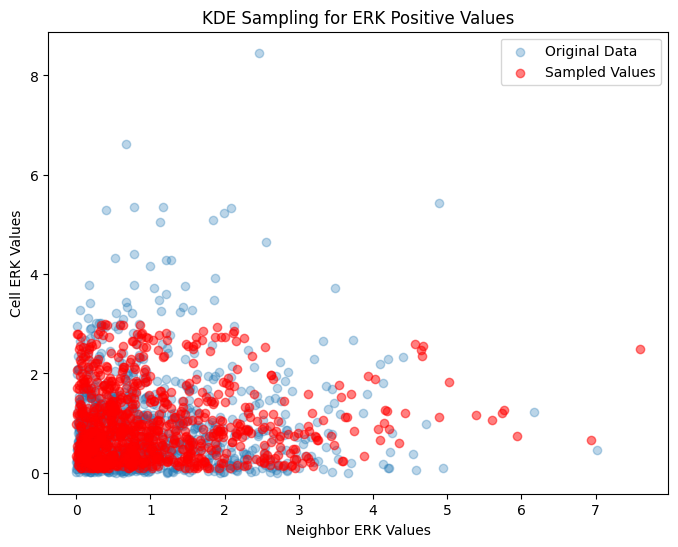

In [20]:
# Example DataFrame with positive values for 'my_erk' and 'neighbor_erk' (replace with real data)
df_ERK = pd.DataFrame({
    'my_erk': np.random.exponential(scale=1.0, size=900),  # Example: Exponentially distributed positive values
    'neighbor_erk': np.random.exponential(scale=1.0, size=900)
})

# Prepare data for KDE
X = df_ERK[['my_erk', 'neighbor_erk']].values

# Fit a 2D kernel density model
kde = KernelDensity(kernel='gaussian', bandwidth=0.1)  # Adjust bandwidth as needed
kde.fit(X)

# Example usage
current_neighbor_values = np.random.exponential(scale=1.0, size=900)  # Replace with real neighbor values
sampled_erk_values = sample_erk_values(current_neighbor_values, kde_model=kde)

# Plot the original data and sampled data
plt.figure(figsize=(8, 6))
plt.scatter(df_ERK['my_erk'], df_ERK['neighbor_erk'], alpha=0.3, label="Original Data")
plt.scatter(current_neighbor_values, sampled_erk_values, color='red', alpha=0.5, label="Sampled Values")
plt.xlabel("Neighbor ERK Values")
plt.ylabel("Cell ERK Values")
plt.legend()
plt.title("KDE Sampling for ERK Positive Values")
plt.show()

Usage on real data.
Before:

In [26]:

# For experiment 1, field of view 1, t = 0, compare real ERK values and sampled ERK values
from scipy.spatial import Voronoi
T = 1
df_WT = df[df['Image_Metadata_Site'] <= 4]
df_WT_Field = df_WT[(df_WT['Image_Metadata_Site'] == 1) & (df_WT['Exp_ID'] == 1)]


ERK_real = df_WT_Field[df_WT_Field['Image_Metadata_T'] == T]['ERKKTR_ratio'].values

# Sample knowing neigbors and your own ERK in t = 1
points = df_WT_Field[df_WT_Field['Image_Metadata_T'] == T][['track_id','objNuclei_Location_Center_X', 'objNuclei_Location_Center_Y']].values
vor = Voronoi(points[1:])

#eighbors = {i: set() for i in range(1, len(points) + 1)}
neighbors = {track_id: set() for track_id in points[:, 0]}
for p1, p2 in vor.ridge_points:
    neighbors[points[p1][0]].add(points[p2][0])
    neighbors[points[p2][0]].add(points[p1][0])

sampled_values = []
for cell in points[:, 0]:
    my_erk = df_WT_Field[(df_WT_Field['Image_Metadata_T'] == T - 1) & (df_WT_Field['track_id'] == cell)]['ERKKTR_ratio'].values
    if len(my_erk) == 0:
        sampled_values.append(None)
        continue
    else:
        my_erk = my_erk[0]

    neighbor_values = []
    for neighbor in neighbors[cell]:
      array_values = (df_WT_Field[(df_WT_Field['Image_Metadata_T'] == T - 1) & (df_WT_Field['track_id'] == neighbor)]['ERKKTR_ratio'].values)
      if len(array_values) > 0:
        neighbor_values.append(array_values[0])

    neighbor_values.append(my_erk)
    sampled_value = sample_erk_values(neighbor_values, kde_model=kde)
    sampled_values.append(sampled_value[0])


# calculate MSE some values are None in sampled_values
sampled_values = np.where(sampled_values == None, np.nan, sampled_values).astype(float)

mask = ~np.isnan(sampled_values)

# Filter arrays
filtered_sampled_values = sampled_values[mask]
filtered_ERK_real = ERK_real[mask]

# Calculate MSE
mse = np.mean((filtered_sampled_values - filtered_ERK_real) ** 2)
print(filtered_sampled_values)
print(filtered_ERK_real)
print(f"Mean Squared Error (MSE): {mse}")

[0.89090909 0.45151515 0.1        ... 0.92020202 0.71515152 0.89090909]
[0.848242 1.23044  0.747578 ... 0.743679 0.482914 0.757003]
Mean Squared Error (MSE): 0.6184732905151381


After :

In [25]:
def sample_multiple_fields(df, exp_id, field_of_view, t_prefix, kde):
    # Filter the DataFrame once
    df_Field = df[(df['Image_Metadata_Site'] == field_of_view) & (df['Exp_ID'] == exp_id) ].copy()

    # Create a lookup dictionary for ERKKTR_ratio by (T, track_id)
    erk_lookup = df_Field.set_index(['Image_Metadata_T', 'track_id'])['ERKKTR_ratio'].to_dict()

    # Group the DataFrame by Image_Metadata_T for faster access
    grouped_T = df_Field.groupby('Image_Metadata_T')

    # Precompute Voronoi neighbors for each time point
    neighbors_dict = {}
    for i in range(1, t_prefix + 1):
        group = grouped_T.get_group(i) if i in grouped_T.groups else pd.DataFrame()
        points = group[['objNuclei_Location_Center_X', 'objNuclei_Location_Center_Y']].values
        if len(points) < 2:
            neighbors_dict[i] = {}
            continue
        vor = Voronoi(points)
        
        # Initialize neighbors for each cell (1-based indexing)
        neighbors = {idx + 1: set() for idx in range(len(points))}
        for p1, p2 in vor.ridge_points:
            neighbors[p1 + 1].add(p2 + 1)
            neighbors[p2 + 1].add(p1 + 1)
        neighbors_dict[i] = neighbors

    sampled_values = []
    # Iterate through each time point and compute ERK relationships
    for i in range(1, t_prefix + 1):
        group = grouped_T.get_group(i) if i in grouped_T.groups else pd.DataFrame()
        if group.empty:
            continue
        
        neighbors = neighbors_dict.get(i, {})
        
        for cell in group['track_id']:
            my_erk = erk_lookup.get((i, cell))
            if my_erk is None:
                continue
            
            neighbor_erk = []
            
            # Get my ERK at t-1
            my_erk_t_minus_1 = erk_lookup.get((i - 1, cell))
            if my_erk_t_minus_1 is not None:
                neighbor_erk.append(my_erk_t_minus_1)
            
            # Get neighbors' ERK at t-1
            for neighbor in neighbors.get(cell, []):
                neighbor_val = erk_lookup.get((i - 1, neighbor))
                if neighbor_val is not None:
                    neighbor_erk.append(neighbor_val)
            
            if neighbor_erk:
                sampled_value = sample_erk_values(neighbor_erk, kde_model=kde)
                sampled_values.append([sampled_value[0], cell, i])


    # Create the final DataFrames
    df_sampled_ERK = pd.DataFrame(sampled_values, columns=['erk', 'cell', 'time']).dropna()

    # Reset index if needed
    df_sampled_ERK.reset_index(drop=True, inplace=True)
    return df_sampled_ERK

# Test the sampling for given prefix T, experiment no 1, field of view no 1
T = 1

# Extract real ERK values at time T
df_real_ERK = df[
    (df['Image_Metadata_Site'] == 1) &
    (df['Exp_ID'] == 1) &
    (df['Image_Metadata_T'] == T)
][['track_id', 'ERKKTR_ratio']].copy()

# Get samples for all time points from the given prefix, using previously computed kernel
df_sampled_ERK = sample_multiple_fields(df, 1, 1, T, kde)
print("Sampled ERK Values (First 5 Rows):")
print(df_sampled_ERK.head())

# Compare the real ERK values in the last time point T with the sampled ones
# Extract sampled ERK values at time T
df_sampled_time = df_sampled_ERK[df_sampled_ERK['time'] == T].copy()

# Merge sampled ERK with real ERK on 'cell' and 'track_id'
df_merged = df_sampled_time.merge(
    df_real_ERK,
    left_on='cell',
    right_on='track_id',
    how='inner',
    suffixes=('_sampled', '_real')
)

# Drop rows with NaN in 'erk' or 'ERKKTR_ratio'
df_merged = df_merged.dropna(subset=['erk', 'ERKKTR_ratio'])

# Extract the sampled and real ERK values as NumPy arrays
filtered_sampled_values = df_merged['erk'].astype(float).values
filtered_ERK_real = df_merged['ERKKTR_ratio'].astype(float).values

# Calculate MSE
mse = np.mean((filtered_sampled_values - filtered_ERK_real) ** 2)
print("\nFiltered Sampled ERK Values:", filtered_sampled_values)
print("Filtered Real ERK Values:", filtered_ERK_real)
print(f"Mean Squared Error (MSE): {mse}")

Sampled ERK Values (First 5 Rows):
        erk  cell  time
0  0.656566     1     1
1  0.480808     2     1
2  0.861616     3     1
3  0.158586     4     1
4  1.066667     5     1

Filtered Sampled ERK Values: [0.65656566 0.48080808 0.86161616 ... 1.0959596  1.15454545 0.45151515]
Filtered Real ERK Values: [0.848242 1.23044  0.747578 ... 0.743679 0.482914 0.757003]
Mean Squared Error (MSE): 0.6231910467220497
